#### Introduction 

The purpose of this notebook is to provide a demo of how you may want to use the package `popexposure` to count people living near environmental hazards. 

This notebook cleans some raw data files for use in the `popexposure` functions, and then the subsequent two notebooks run the functions and explore results. 

Prerequisites: This demo assumes that you have a version of Python installed on your computer compatible with the requirements of `popexposure`, you have an IDE, and you’re able to open and run a Jupyter notebook as well as Python scripts, and activate a virtual environment in which to run this notebook and `popexposure`. Congrats! If you're reading this you probably opened the notebook and hopefully can run it! 

#### Outline
1. What are we doing in this demo?
2. Activating the pop_exp environment
3. Data used in this demo
4. What can `popexposure` do?
5. Data preparation

##### What are we doing in this demo? 

This demo will teach you how to use `popexposure` to find the number of people residing near California wildfire disasters, as well as the number of people residing near California wildfire disasters by ZCTA, across the years 2016-2018. We will discuss the details of how `popexposure` allows you to define exposure to environmental hazards shortly. 

`popexposure` means Population Exposure. 

#### Activating the pop_exp environment

We've provided an environment file that contains the requirments of `popexposure` in the same GitHub folder as this demo. If you're running a script that loads and runs `popexposure` functions from the command line, you can install and activate this environment before you run that script from the command line. If you want to run this demo or your own notebook that uses `popexposure`, you can install this environment, make a Jupyter kernel, and run the notebook in it. 

Briefly, if you wanted to run a script using `popexposure` from the command line, you could:

1. Open a terminal window and navigate to this repository using cd.
2. Create the environment by running: conda env create -f pop_exp.yml
3. Activate this environment using: conda activate pop_exp
4. Run your script.

To create a kernel, you need to run:
python -m ipykernel install --user --name pop_exp --display-name "Python (pop_exp)"

#### Data used in this demo

Functions available in `popexposure`: `popexposure` allow the user to estimate either (a) the number of people living within a buffer distance of each unique hazard (e.g., the number of people living within 10 km of each individual wildfire disaster burned area in 2018 in California) or (b) the number of people living within the buffer distance of any of the cumulative set of hazards (e.g., the number of people living within 10 km of one or more wildfire disaster burned areas in 2018 in California). These estimates can be broken down by additional administrative units such as ZCTAs; for example, `popexposure` can find the number of people living within 10 km of any wildfire disaster burned area in 2018 by ZCTA, and calculate administrative unit denominators such as the number of residents in each ZCTA. 

In this demo, we'll use a publicly available dataset of US wildfire disaster boundaries for the years 2016-2018 filtered to California as our hazard data, and demonstrate all the different ways `popexposure` can be used to do detemine population exposure. 

To create these estimates, `popexposure` can takes up to four inputs: (1) a geospatial dataset of environmental hazards, (2) a gridded population dataset, (3) a parameter indicating whether the estimates are hazard-specific or cumulative (i.e. one count for the number of people affected for each unique hazard or one count for the total people living near one or more hazards), and (4) an optional additional geospatial dataset of administrative geographies such as postal codes, census tracts, or counties.

If you want to run this demo yourself, you can run the code below that creates a directory within the demo folder called demo_data, and populate the 01_raw_data folder with the three files listed below. This code also creates 02_interim_data, and 03_results, as subdirectories of the demo_data folder. This demo will populate those folders. Note that the raster dataset may take a few minutes to download depending on your internet, so you may want to start the download before you intend to work through the demo. 

A description of the wildfire dataset and a link for download is available here: 

Description:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/R73R85
Download link:
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/R73R85#

This demo will show how to find the number of people residing within a buffer of these wildfires by ZCTA, so we'll also use a shapefile of 2020 ZCTAs, described in detail and available for download here:

Description:
https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html
Download link:
https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/tl_2020_us_zcta520.zip

For the required gridded population data, which is used by the function to determine how many people live where, we'll use the version of the Global Human Settlement Layer which describes the residential population of the globe at 100 m resolution for 2020, and download only the tile that covers California. We used the file with Mollweide coordinate reference system, but any would work. It's downloadable here: 

Description:
https://human-settlement.emergency.copernicus.eu/download.php?ds=pop
Download:
https://jeodpp.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GLOBE_R2023A/GHS_POP_E2020_GLOBE_R2023A_54009_100/V1-0/tiles/GHS_POP_E2020_GLOBE_R2023A_54009_100_V1_0_R5_C8.zip

#### What can popexposure do? 

The Python package popexposure can do five distinct computations. 

1. Find the total number of people who reside within a buffer distance (which can vary by hazard or be 0) of one or more hazards for a set of environmental hazards.
2. Find the total number of people who reside within a buffer distance (which can vary by hazard or be 0) for each unique environmental hazard in a set of hazards.
3. Find the total number of people who reside within a buffer distance (which can vary by hazard or be 0) of one or more hazards for a set of environmental hazards, by additional administrative unit (ex. the total number of people who resided within 10km of any wildfire disaster in 2018 by ZCTA).
4. Find the total number of people who reside within a buffer distance (which can vary by hazard or be 0) for each unique environmental hazard in a set of hazards, by additional 
administrative unit. 
5. Find the number of people living within each administrative unit according to a gridded population dataset. 

The fifth function is meant to provide denominators for computations (3) and (4). For example, you may want to find the total number of people who lived within 10km of any wildfire disaster in 2018 by ZCTA, and then calculate the proportion of the ZCTA population that was exposed. To do this, you could use a function in popexposure to find the ZCTA population according to the gridded population raster you used to determine exposure. 

This demo will show all of these options. 


To demo all the functions available in popexposure, we will do five separate computations, which align with the five options available in the package. 

1. Find the total number of people residing within 10km of one or more California wildfire 
disaster in 2016, 2017, and 2018. 
2. Find the total number of people residing within 10 km of each unique California wildfire
disaster in 2016, 2017, and 2018.
3. Find the total number of people residing within 10km of one or more California wildfire 
disaster in 2016, 2017, and 2018 by 2020 ZCTA. 
4. Find the total number of people residing within 10 km of each unique California wildfire
disaster in 2016, 2017, and 2018 by 2020 ZCTA.
5. Find the population of all 2020 California ZCTAs. 

To do the first four computations, we need to first call the prep_data function, 
and then call the popexposure function est_exposed_pop. 

For est_exposed_pop, the function parameter hazard_specific allows us to specify 
whether we want to calculate one total count of people living near one or more 
environmental hazards in the set (hazard_specific = False), or if we want to 
find the number of people living near each unique hazard in the set 
(hazard_specific = True). 

To break counts down by ZCTA, we'll need to pass additional ZCTA data to the 
function est_exposed_pop. This ZCTA data is optional. When there is no ZCTA data, 
the function will by default return counts without additional administrative units, 
whether they are hazard-specific or not. When administrative unit data are passed, 
counts will automatically be broken down by administrative unit, hazard-specific or not. 

However, before we call anything, we need to get the right data to pass to 
prep_data and est_exposed_pop. 

#### Data preparation

This is where we start coding! First we import some libraries. 

In [1]:
import pathlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os

We'll start by preparing the wildfire data. We'll set directories, and then 
read in the raw wildfire data as downloaded from Harvard dataverse. Note that
the raw data contains wildfire disasters for years 2000-2019, which is a lot, 
and we're going to filter down to only 2016-2018 for this tutorial. 

In [2]:
base_path = pathlib.Path.cwd().parent
data_dir = base_path / "demo_data"

# create subdirectories if not already existing
subfolders = ['01_raw_data', '02_interim_data', '03_results']

# make data dir and subfolders
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    if not os.path.exists(subfolder_path):
        os.makedirs(subfolder_path)

In [3]:
# read in US wildfire dataset
fires = gpd.read_file(data_dir / "01_raw_data"/ "wfbz_disasters_conus.geojson")
# filter to only CA fires - wildfire_states has to contain CA
fires = fires[fires['wildfire_states'].str.contains('CA')]

We'll plot the data to make sure the dataset read in correctly.

<Axes: >

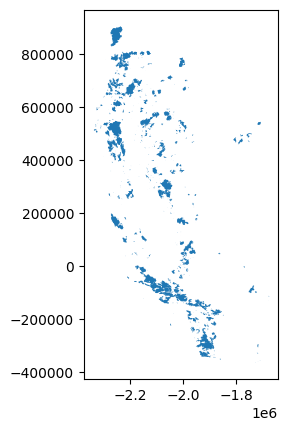

In [4]:
fires.plot()

For prep_data, we need to pass a path to a hazard dataframe with at least
3 columns:  ID_hazard, at least one column starting with buffer_dist, and 
geometry. So we need to decide on one or more buffer distances and create those
columns, and rename the other columns to the correct names. 

For this demo, we've decided we want to consider people exposed to a wildfire
if they live within 10 km of the boundaries of the wildfire disasters that are
specified in my dataset. You could do something different if you think the 
relevant distance from your hazard is different. You can also assign a buffer
of 0 to your hazards, or different buffers to each hazard in your dataset. They
don't all have to be the same. You could even assign buffers based on the hazard
area, or another characteristic of each hazard.

The buffer distance is in meters, so we'll specify a 10,000 m buffer distance. 

If we wanted to also see how many people were within 20 km of the wildfire 
boundaries, we could add another column with a 20,000 m buffer distance. This 
might be useful if you're doing environmental epi and want to run sensitivity 
analyses on your choice of buffer distance ;).

We'll call our column buffer_dist_10 since it is a 10km buffer distance. 

In [5]:
fires["buffer_dist_10"] = 10000 # buffer distance in in meters 
fires.head # Checking what columns we have in the data 

<bound method NDFrame.head of                                    wildfire_id  wildfire_year wildfire_states  \
4              2000-08-27_HUNTER_CA_MARIPOSA_5         2000.0              CA   
5                   2000-07-22_HAPPY_CA_INYO_6         2000.0              CA   
6                 2000-09-19_CONCOW_CA_BUTTE_7         2000.0              CA   
7              2000-08-17_COOLEY_CA_SISKIYOU_8         2000.0              CA   
8         2000-06-13_BERRYESSA_CA_SACRAMENTO_9         2000.0              CA   
...                                        ...            ...             ...   
5452        2002-07-03_GONDOLA_NV_DOUGLAS_5453         2002.0           CA,NV   
5513              2009-08-30_49_CA_PLACER_5514         2009.0              CA   
5515     2010-09-09_GLENVIEW_CA_SAN MATEO_5516         2010.0              CA   
5565  2014-08-01_OREGON GULCH_CA_SISKIYOU_5566         2014.0           CA,OR   
5593         2018-08-09_HOLY_CA_RIVERSIDE_5594         2018.0              CA  

We've created a buffer distance column. We need to select and rename the
remaining columns we need, but we also need to select the years 
we're interested in. 

Here, we're interested in years 2016-2018, and we want to determine 
exposure by year. We want to compute the total number of people affected by any 
fire in 2016, 2017, and 2018, as well as apply the three other exposure definitions we
wrote out above yearly.

There is no option in popexposure to indicate which hazards are for which year, or time period. If we want to know the total number of people affected by hazards in 2016 but not 2017, we need to feed popexposure the exposure data for 2016 along with a gridded population dataset that represents the population in 2016. If I wanted monthly exposure for 2016, I'd need to split my exposure data up by month and call the function separately on each month. 

In this demo, we'll use the GHSL data from 2020 for each year 2016-2018, since it's close enough, but split up the hazard data by year because we want yearly counts.

So before selecting just the ID, hazard, and buffer distance columns, we're going to select and split up the years we're interested in. 

In [6]:
# Select fires in 2016, 2017, 2018
fires = fires[fires["wildfire_year"].isin([2016, 2017, 2018])]
# Split this into a list of dataframes by year
fires_by_year = [fires[fires["wildfire_year"] == year] for year in [2016, 2017, 2018]]

Now that we have our exposure datasets, we'll select and rename the columns we need
for `popexposure` functions: ID_hazard, the buffer_dist column, and geometry. 

In [7]:
# First, select cols
fires_by_year = [fire[["wildfire_id", "buffer_dist_10", "geometry"]] for fire in fires_by_year]
# Then rename the wildfire ID col
fires_by_year = [fire.rename(columns={"wildfire_id": "ID_hazard"}) for fire in fires_by_year]

Finally, we can write these out into an interim data folder to call 
using the popexposure function, since the popexposure function requires you to pass 
a path name, not an object in Python. We're using GeoJSON files because these functions require either GeoJSON or Parquet. 

In [8]:
for i, fire in enumerate(fires_by_year):
    fire.to_file(data_dir / "02_interim_data" / f"wildfires_{2016 + i}.geojson", driver="GeoJSON")

We've dealt with the wildfire disaster exposure data which is going to be our
environmental hazard data. Now we also need to get the ZCTA data into the right
format. 

We've chosen to use 2020 ZCTA data, since the time period 2016-2018 is closer to the 2020 census than the 2010 census. We'll read in the data, and then select and rename the columns to be what the prep_data function requires.

We need to rename the ZCTA ID to 'ID_admin_unit'. 

In [9]:
# I'm reading in the raw ZCTA data. 
zctas = gpd.read_file(data_dir / "01_raw_data" / "tl_2020_us_zcta520" / "tl_2020_us_zcta520.shp")

# Rename 
zctas.rename(columns={"ZCTA5CE20": "ID_admin_unit"}, inplace=True)
# select ID_admin_unit and geometry
zctas = zctas[["ID_admin_unit", "geometry"]].copy()
zctas.head

<bound method NDFrame.head of       ID_admin_unit                                           geometry
0             35592  POLYGON ((-88.24735 33.6539, -88.24713 33.6541...
1             35616  POLYGON ((-88.13997 34.58184, -88.13995 34.582...
2             35621  POLYGON ((-86.81659 34.3496, -86.81648 34.3496...
3             35651  POLYGON ((-87.53087 34.42492, -87.53082 34.429...
4             36010  POLYGON ((-85.95712 31.67744, -85.95676 31.677...
...             ...                                                ...
33786         10540  POLYGON ((-73.7358 41.33577, -73.73501 41.3358...
33787         23081  POLYGON ((-76.79774 37.21409, -76.79134 37.220...
33788         23147  POLYGON ((-77.04292 37.36996, -77.04143 37.370...
33789         23298  POLYGON ((-77.43284 37.54038, -77.43262 37.540...
33790         12544  POLYGON ((-73.67796 42.26914, -73.66474 42.265...

[33791 rows x 2 columns]>

Then, after selecting just ZCTAs in California, we'll save this as a GeoJSON file as well. This additional admin unit 
file can also be in GeoJSON or Parquet format. 

In [10]:
# Filter to zctas in CA
zctas = zctas[pd.to_numeric(zctas['ID_admin_unit']).between(90000, 96162)].copy()


In [11]:
# This will take a few seconds. 
zctas_path = data_dir / "02_interim_data" / "zctas_CA_2020.geojson"
zctas.to_file(zctas_path, driver = 'GeoJSON')


Since the gridded population raster doesn't require any preprocessing, our 
data is ready! Proceed to 02_demo_example_run.ipynb to continue the demo. 